# 🧠 Brain Tumor MRI Image Classification

## 📌 Project Objective
The objective of this project is to build a deep learning–based image classification system
that can accurately classify brain MRI images into different tumor categories.

The project includes:
- Dataset exploration and preprocessing
- Image augmentation
- Model building using CNN and Transfer Learning
- Model evaluation and comparison
- Saving trained models
- Deployment using Streamlit

## 🧪 Domain
Medical Imaging — Deep Learning Image Classification

## 🛠 Tools & Technologies
- Python
- TensorFlow / Keras
- NumPy, Pandas, Matplotlib, Seaborn
- OpenCV / PIL
- Scikit-learn
- Streamlit


📘 Cell 2 – Environment & Library Imports

In [2]:
# Core Libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import cv2
from PIL import Image

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.20.0


📘 Cell 3 – Dataset Directory Structure & Verification

In [8]:
# Base dataset directory
BASE_DIR = "data"

# Subdirectories
train_dir = os.path.join(BASE_DIR, "train")
valid_dir = os.path.join(BASE_DIR, "valid")
test_dir  = os.path.join(BASE_DIR, "test")

# Verify directories
for directory in [train_dir, valid_dir, test_dir]:
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Missing directory: {directory}")

# Get class names from training folder
class_names = sorted(os.listdir(train_dir))
print("Class Names:", class_names)

# Count images in each split
def count_images(folder):
    for cls in class_names:
        cls_path = os.path.join(folder, cls)
        print(f"{os.path.basename(folder)} | {cls}: {len(os.listdir(cls_path))} images")

print("\nTraining Data:")
count_images(train_dir)

print("\nValidation Data:")
count_images(valid_dir)

print("\nTest Data:")
count_images(test_dir)


Class Names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']

Training Data:
train | glioma: 564 images
train | meningioma: 358 images
train | no_tumor: 335 images
train | pituitary: 438 images

Validation Data:
valid | glioma: 161 images
valid | meningioma: 124 images
valid | no_tumor: 99 images
valid | pituitary: 118 images

Test Data:
test | glioma: 80 images
test | meningioma: 63 images
test | no_tumor: 49 images
test | pituitary: 54 images


📘 Cell 4 – Sample Image Visualization (EDA)

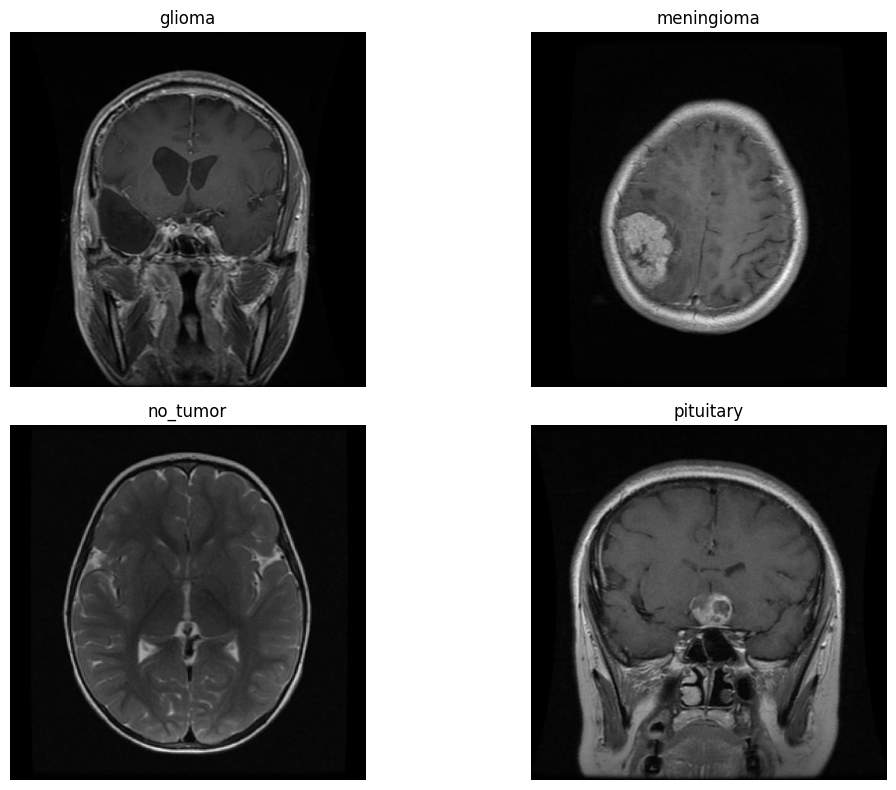

In [8]:
# Display sample images from each class
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    img_name = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


📘 Cell 5 – Image Size Analysis & Standardization

Image Size Statistics:
       Height  Width
count   200.0  200.0
mean    640.0  640.0
std       0.0    0.0
min     640.0  640.0
25%     640.0  640.0
50%     640.0  640.0
75%     640.0  640.0
max     640.0  640.0


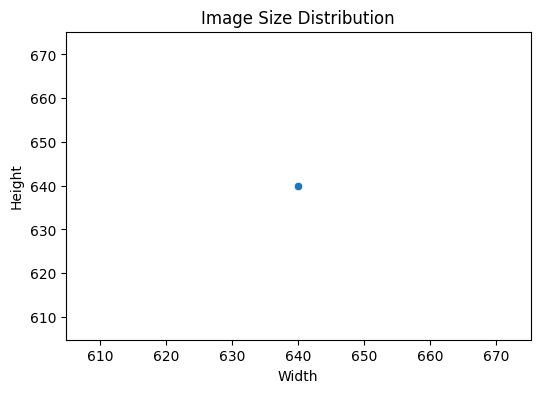

In [9]:
# Analyze image dimensions across the dataset
image_sizes = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path)[:50]:  # sample up to 50 images per class
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            image_sizes.append(img.shape[:2])  # (height, width)

# Convert to DataFrame for analysis
sizes_df = pd.DataFrame(image_sizes, columns=["Height", "Width"])

print("Image Size Statistics:")
print(sizes_df.describe())

# Plot distribution
plt.figure(figsize=(6, 4))
sns.scatterplot(x=sizes_df["Width"], y=sizes_df["Height"])
plt.title("Image Size Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


📘 Cell 6 – Image Preprocessing Strategy (Resizing & Normalization)

In [5]:
# Standard image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

print(f"Standard Image Size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")

# Image preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img


Standard Image Size: 224x224x3


Cell 7 – Data Augmentation Strategy (Training Only) 🔄

In [6]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data (NO augmentation)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

print("Data generators initialized successfully")


Data generators initialized successfully


📘 Cell 8 – Create Train, Validation & Test Data Generators
📌 Purpose of this Cell

Load images directly from directory

Apply augmentation only to training

Create generators compatible with CNN + Transfer Learning models

This step is mandatory before model training

In [9]:
# Parameters
BATCH_SIZE = 32
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Class indices
print("Class Indices:", train_generator.class_indices)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.
Class Indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


📘 Cell 9 – Baseline Custom CNN Model Architecture
Purpose of this Cell

Build a CNN from scratch

Establish a performance baseline

Compare later with MobileNet, ResNet, etc.

Important for academic evaluation

In [11]:
# Number of classes
NUM_CLASSES = train_generator.num_classes

# Custom CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

📘 Cell 10 – Train Baseline CNN Model
📌 Purpose of this Cell

Train the custom CNN

Use EarlyStopping to avoid overfitting

Save the best model automatically

Generate history for evaluation

In [11]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "cnn_baseline_best.keras",   # ✅ modern recommended format
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Training
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)



Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5174 - loss: 1.5292
Epoch 1: val_accuracy improved from None to 0.23506, saving model to cnn_baseline_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5121 - loss: 1.4073 - val_accuracy: 0.2351 - val_loss: 16.1173
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4783 - loss: 1.1857
Epoch 2: val_accuracy did not improve from 0.23506
53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4590 - loss: 1.2103 - val_accuracy: 0.2351 - val_loss: 20.4498
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4641 - loss: 1.2112
Epoch 3: val_accuracy improved from 0.23506 to 0.24900, saving model to cnn_baseline_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.4791 - loss: 1.2647 - val_accuracy: 0.2490 - val_loss: 4.8863
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4754 - loss: 1.3590
Epoch 4: val_accuracy improved from 0.24900 to 0.42430, saving model to cnn_ba

📘 Cell 11 – Baseline CNN Evaluation & Metrics
📌 Purpose of this Cell

Evaluate performance on test data

Generate:

Accuracy

Confusion Matrix

Classification Report

These results will be used later for model comparison



8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.1789 - loss: 1.3871
Test Accuracy: 0.1789
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.24      0.39      0.29        80
  meningioma       0.25      0.02      0.03        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.11      0.22      0.15        54

    accuracy                           0.18       246
   macro avg       0.15      0.16      0.12       246
weighted avg       0.16      0.18      0.14       246



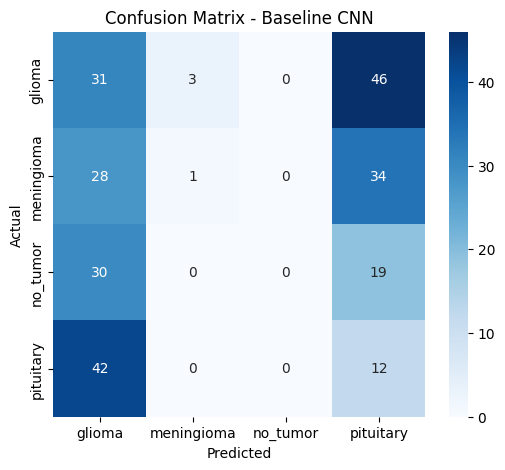

In [42]:
# Evaluate on test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
test_generator.reset()
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline CNN")
plt.show()


In [43]:
y_true = test_generator.classes
y_pred = np.argmax(cnn_model.predict(test_generator), axis=1)


np.save("reports/cnn_y_true.npy", y_true)
np.save("reports/cnn_y_pred.npy", y_pred)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step


In [44]:
np.save("reports/class_names.npy", train_generator.class_indices)

📘 Cell 12 – MobileNetV2 Model Setup (Transfer Learning)
📌 Purpose of this Cell

Load pretrained MobileNetV2 (ImageNet weights)

Freeze base layers

Add custom classification head

Compile the model

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False

# Build transfer learning model
mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
mobilenet_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,427,588 (9.26 MB)

 Trainable params: 167,044 (652.52 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

📘 Cell 13 – Train MobileNetV2 Model (Save as .keras)
📌 Purpose of this Cell

Train MobileNetV2 using transfer learning

Use EarlyStopping to avoid overfitting

Save the best-performing MobileNetV2 model

Keep results for later comparison with other models

In [41]:
# Callbacks for MobileNetV2
early_stop_mobilenet = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_mobilenet = ModelCheckpoint(
    "mobilenetv2_best.keras",   # ✅ modern format
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train MobileNetV2
history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stop_mobilenet, checkpoint_mobilenet]
)



Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8715 - loss: 0.3956
Epoch 1: val_accuracy improved from None to 0.85060, saving model to mobilenetv2_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8655 - loss: 0.3733 - val_accuracy: 0.8506 - val_loss: 0.4125
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8881 - loss: 0.3049
Epoch 2: val_accuracy did not improve from 0.85060
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8991 - loss: 0.2789 - val_accuracy: 0.8486 - val_loss: 0.4121
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9138 - loss: 0.2302
Epoch 3: val_accuracy improved from 0.85060 to 0.85857, saving model to mobilenetv2_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9115 - loss: 0.2450 - val_accuracy: 0.8586 - val_loss: 0.4053
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9151 - loss: 0.2139
Epoch 4: val_accuracy improved from 0.85857 to 0.87052, saving model to mobilenetv2_b

📘 Cell 14 – MobileNetV2 Evaluation & Metrics
📌 Purpose of this Cell

Evaluate MobileNetV2 on test data

Generate:

Test accuracy

Classification report

Confusion matrix

Compare later with CNN baseline and other mod

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 988ms/step - accuracy: 0.7764 - loss: 0.5978
MobileNetV2 Test Accuracy: 0.7764
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 853ms/step

Classification Report (MobileNetV2):
              precision    recall  f1-score   support

      glioma       0.89      0.85      0.87        80
  meningioma       0.80      0.51      0.62        63
    no_tumor       0.97      0.76      0.85        49
   pituitary       0.59      1.00      0.74        54

    accuracy                           0.78       246
   macro avg       0.81      0.78      0.77       246
weighted avg       0.82      0.78      0.77       246



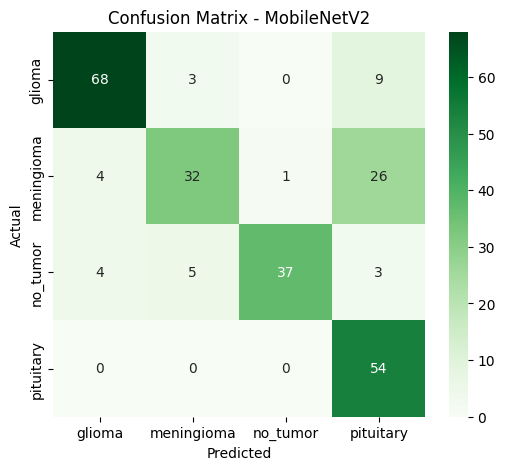

In [22]:
# Evaluate MobileNetV2 on test data
test_loss_mn, test_accuracy_mn = mobilenet_model.evaluate(test_generator)
print(f"MobileNetV2 Test Accuracy: {test_accuracy_mn:.4f}")

# Predictions
test_generator.reset()
y_pred_probs_mn = mobilenet_model.predict(test_generator)
y_pred_mn = np.argmax(y_pred_probs_mn, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report (MobileNetV2):")
print(classification_report(y_true, y_pred_mn, target_names=class_labels))

# Confusion matrix
cm_mn = confusion_matrix(y_true, y_pred_mn)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_mn, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MobileNetV2")
plt.show()


In [45]:
y_true = test_generator.classes
y_pred = np.argmax(mobilenet_model.predict(test_generator), axis=1)


np.save("reports/mobilenet_y_true.npy", y_true)
np.save("reports/mobilenet_y_pred.npy", y_pred)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 683ms/step


In [46]:
np.save("reports/class_names.npy", train_generator.class_indices)

📘 Cell 15 – ResNet50 Model Setup
📌 Purpose of this Cell

Load pretrained ResNet50 (ImageNet)

Freeze base layers

Add custom classification head

Compile the model

In [18]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 base model
resnet_base = ResNet50(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    include_top=False,
    weights='imagenet'
)

# Freeze base layers
resnet_base.trainable = False

# Build ResNet50 model
resnet_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
resnet_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,121,476 (92.02 MB)

 Trainable params: 529,668 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

📘 Cell 16 – Train ResNet50 Model (Save as .keras)
📌 Purpose of this Cell

Train ResNet50 using transfer learning

Use EarlyStopping

Save the best ResNet50 model

Keep results for final comparison

In [24]:
# Callbacks for ResNet50
early_stop_resnet = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_resnet = ModelCheckpoint(
    "resnet50_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train ResNet50
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    
    callbacks=[early_stop_resnet, checkpoint_resnet]
)



Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7796 - loss: 0.5600
Epoch 1: val_accuracy improved from None to 0.79681, saving model to resnet50_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.7900 - loss: 0.5602 - val_accuracy: 0.7968 - val_loss: 0.5494
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7832 - loss: 0.5789
Epoch 2: val_accuracy did not improve from 0.79681
53/53 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.7799 - loss: 0.5825 - val_accuracy: 0.7948 - val_loss: 0.5571
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7765 - loss: 0.5497
Epoch 3: val_accuracy did not improve from 0.79681
53/53 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.7705 - loss: 0.5732 - val_accuracy: 0.7908 - val_loss: 0.5289
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7659 - loss: 0.5875
Epoch 4: val_accuracy improved from 0.79681 to 0.81474, saving model to resnet50_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/st

📘 Cell 17 – ResNet50 Evaluation & Metrics
📌 Purpose of this Cell

Evaluate ResNet50 on test data

Generate:

Test accuracy

Classification report

Confusion matrix

Store results for final model comparison

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7927 - loss: 0.5278
ResNet50 Test Accuracy: 0.7927
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step

Classification Report (ResNet50):
              precision    recall  f1-score   support

      glioma       0.84      0.78      0.81        80
  meningioma       0.65      0.68      0.67        63
    no_tumor       0.81      0.78      0.79        49
   pituitary       0.88      0.96      0.92        54

    accuracy                           0.79       246
   macro avg       0.79      0.80      0.80       246
weighted avg       0.79      0.79      0.79       246



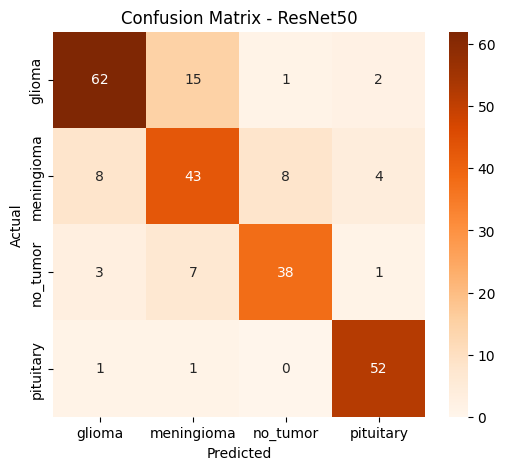

In [25]:
# Evaluate ResNet50 on test data
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_generator)
print(f"ResNet50 Test Accuracy: {test_accuracy_resnet:.4f}")

# Predictions
test_generator.reset()
y_pred_probs_resnet = resnet_model.predict(test_generator)
y_pred_resnet = np.argmax(y_pred_probs_resnet, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report (ResNet50):")
print(classification_report(y_true, y_pred_resnet, target_names=class_labels))

# Confusion matrix
cm_resnet = confusion_matrix(y_true, y_pred_resnet)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_resnet, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet50")
plt.show()


In [35]:
import os
os.makedirs("reports", exist_ok=True)


In [29]:
y_true = test_generator.classes
y_pred = np.argmax(resnet_model.predict(test_generator), axis=1)


np.save("reports/resnet_y_true.npy", y_true)
np.save("reports/resnet_y_pred.npy", y_pred)


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


In [30]:
np.save("reports/class_names.npy", train_generator.class_indices)


📘 Cell 18 – InceptionV3 Model Setup
📌 Purpose of this Cell

Load pretrained InceptionV3 (ImageNet)

Freeze base layers

Add custom classification head

Compile the model

In [31]:
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3 base model
inception_base = InceptionV3(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    include_top=False,
    weights='imagenet'
)

# Freeze base layers
inception_base.trainable = False

# Build InceptionV3 model
inception_model = Sequential([
    inception_base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
inception_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
inception_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_101              │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,336,548 (85.21 MB)

 Trainable params: 529,668 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

📘 Cell 19 – Train InceptionV3 Model (Save as .keras)
📌 Purpose of this Cell

Train InceptionV3 using transfer learning

Use EarlyStopping

Save the best InceptionV3 model

Prepare for final compariso

In [32]:
# Callbacks for InceptionV3
early_stop_inception = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_inception = ModelCheckpoint(
    "inceptionv3_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train InceptionV3
history_inception = inception_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stop_inception, checkpoint_inception]
)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6402 - loss: 1.1379
Epoch 1: val_accuracy improved from None to 0.68127, saving model to inceptionv3_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7392 - loss: 0.8736 - val_accuracy: 0.6813 - val_loss: 0.8922
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8417 - loss: 0.5757
Epoch 2: val_accuracy improved from 0.68127 to 0.81474, saving model to inceptionv3_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.8330 - loss: 0.5534 - val_accuracy: 0.8147 - val_loss: 0.5052
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8580 - loss: 0.4639
Epoch 3: val_accuracy improved from 0.81474 to 0.85657, saving model to inceptionv3_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8755 - loss: 0.3980 - val_accuracy: 0.8566 - val_loss: 0.3674
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8611 - loss: 0.3638
Epoch 4: val_accuracy improved from 0.

📘 Cell 20 – InceptionV3 Evaluation & Metrics
📌 Purpose of this Cell

Evaluate InceptionV3 on test data

Generate:

Test accuracy

Classification report

Confusion matrix

Prepare results for final comparison


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 811ms/step - accuracy: 0.8984 - loss: 0.3572
InceptionV3 Test Accuracy: 0.8984
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

Classification Report (InceptionV3):
              precision    recall  f1-score   support

      glioma       0.93      0.96      0.94        80
  meningioma       0.86      0.79      0.83        63
    no_tumor       0.91      0.88      0.90        49
   pituitary       0.88      0.94      0.91        54

    accuracy                           0.90       246
   macro avg       0.90      0.89      0.89       246
weighted avg       0.90      0.90      0.90       246



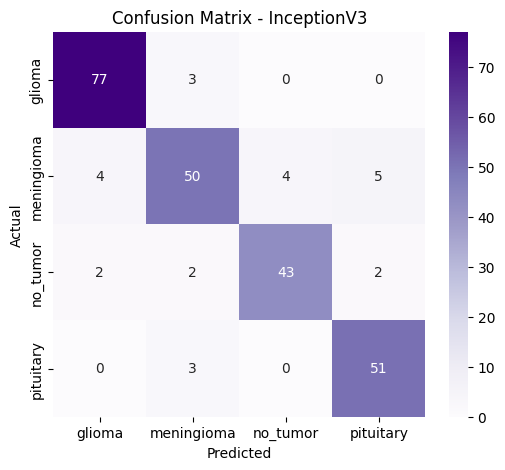

In [33]:
# Evaluate InceptionV3 on test data
test_loss_inc, test_accuracy_inc = inception_model.evaluate(test_generator)
print(f"InceptionV3 Test Accuracy: {test_accuracy_inc:.4f}")

# Predictions
test_generator.reset()
y_pred_probs_inc = inception_model.predict(test_generator)
y_pred_inc = np.argmax(y_pred_probs_inc, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report (InceptionV3):")
print(classification_report(y_true, y_pred_inc, target_names=class_labels))

# Confusion matrix
cm_inc = confusion_matrix(y_true, y_pred_inc)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_inc, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Purples')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - InceptionV3")
plt.show()


In [37]:
import os
os.makedirs("reports", exist_ok=True)

In [39]:
y_true = test_generator.classes
y_pred = np.argmax(inception_model.predict(test_generator), axis=1)


np.save("reports/inceptionv3_y_true.npy", y_true)
np.save("reports/inceptionv3_y_pred.npy", y_pred)


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 861ms/step


In [40]:
np.save("reports/class_names.npy", train_generator.class_indices)






📘 Cell 21 – EfficientNetB0 Model Setup
📌 Purpose of this Cell

Load pretrained EfficientNetB0

Freeze base layers

Add custom classification head

Compile the model

In [23]:
from tensorflow.keras.applications import EfficientNetB0

# Load EfficientNetB0 base model
efficientnet_base = EfficientNetB0(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    include_top=False,
    weights='imagenet'
)

# Freeze base layers
efficientnet_base.trainable = False

# Build EfficientNetB0 model
efficientnet_model = Sequential([
    efficientnet_base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
efficientnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
efficientnet_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

📘 Cell 21.1 – Accuracy & Loss Visualization Function (MANDATORY)
📌 Purpose

Plot Training vs Validation Accuracy

Plot Training vs Validation Loss

Reusable for all models

In [24]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


📘 Cell 21.2 – Plot Curves for All Trained Models

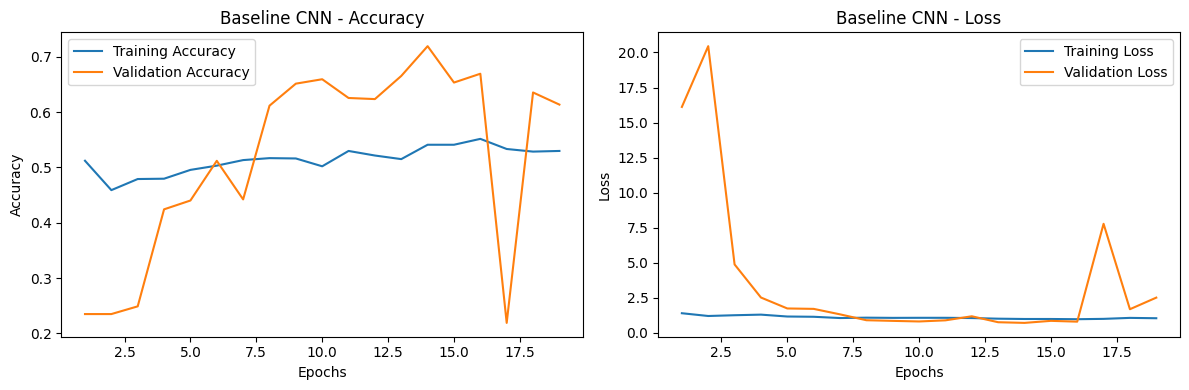

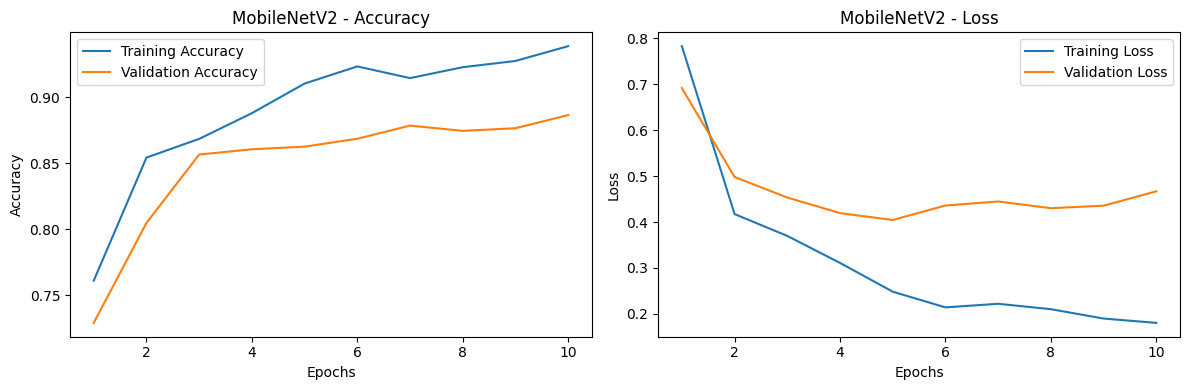

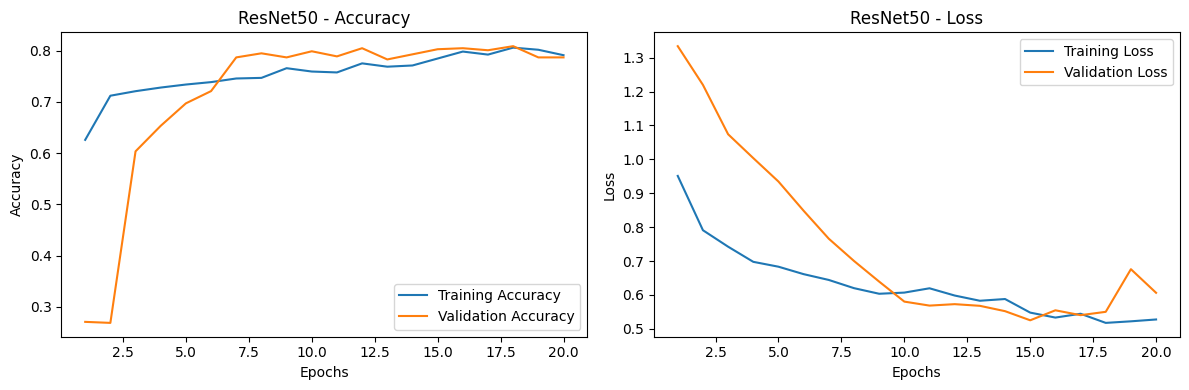

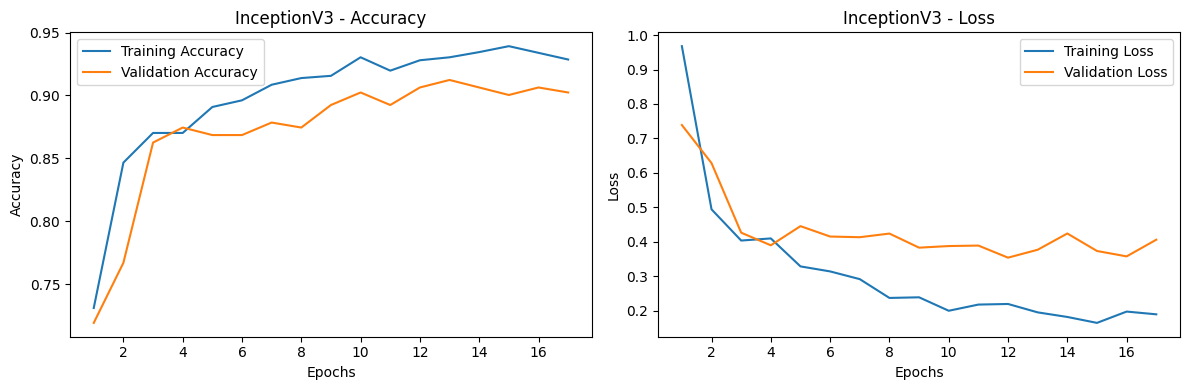

In [27]:
# Baseline CNN
plot_training_history(history_cnn, "Baseline CNN")

# MobileNetV2
plot_training_history(history_mobilenet, "MobileNetV2")

# ResNet50
plot_training_history(history_resnet, "ResNet50")

# InceptionV3
plot_training_history(history_inception, "InceptionV3")


📘 Cell 22 – Train EfficientNetB0 Model (Save as .keras)
📌 Purpose of this Cell

Train EfficientNetB0 using transfer learning

Apply EarlyStopping

Save the best EfficientNetB0 model

Final model in our comparison list

In [26]:
# Callbacks for EfficientNetB0
early_stop_eff = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_eff = ModelCheckpoint(
    "efficientnetb0_best.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train EfficientNetB0
history_efficientnet = efficientnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stop_eff, checkpoint_eff]
)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.2528 - loss: 1.8843
Epoch 1: val_accuracy improved from None to 0.32072, saving model to efficientnetb0_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2749 - loss: 1.8695 - val_accuracy: 0.3207 - val_loss: 1.3685
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3068 - loss: 1.7434
Epoch 2: val_accuracy did not improve from 0.32072
53/53 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.2879 - loss: 1.7784 - val_accuracy: 0.2450 - val_loss: 1.3779
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.3105 - loss: 1.6211
Epoch 3: val_accuracy did not improve from 0.32072
53/53 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.3068 - loss: 1.6475 - val_accuracy: 0.1952 - val_loss: 1.3811
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3409 - loss: 1.5215
Epoch 4: val_accuracy improved from 0.32072 to 0.38446, saving model to efficientnetb0_best.keras
53/53 ━━━━━━━━━━━━━━━━

📘 Cell 23 – EfficientNetB0 Evaluation & Metrics
📌 Purpose of this Cell

Evaluate EfficientNetB0 on test data

Generate:

Test accuracy

Classification report

Confusion matrix

Prepare results for final model comparison

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 826ms/step - accuracy: 0.3252 - loss: 1.3699
EfficientNetB0 Test Accuracy: 0.3252
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

Classification Report (EfficientNetB0):
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



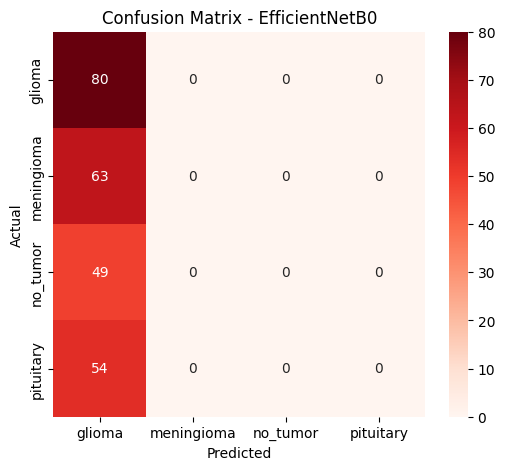

In [28]:
# Evaluate EfficientNetB0 on test data
test_loss_eff, test_accuracy_eff = efficientnet_model.evaluate(test_generator)
print(f"EfficientNetB0 Test Accuracy: {test_accuracy_eff:.4f}")

# Predictions
test_generator.reset()
y_pred_probs_eff = efficientnet_model.predict(test_generator)
y_pred_eff = np.argmax(y_pred_probs_eff, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report (EfficientNetB0):")
print(classification_report(y_true, y_pred_eff, target_names=class_labels))

# Confusion matrix
cm_eff = confusion_matrix(y_true, y_pred_eff)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_eff, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - EfficientNetB0")
plt.show()


📘 Cell 23.1 – Accuracy & Loss Curves for EfficientNetB0 (MANDATORY)

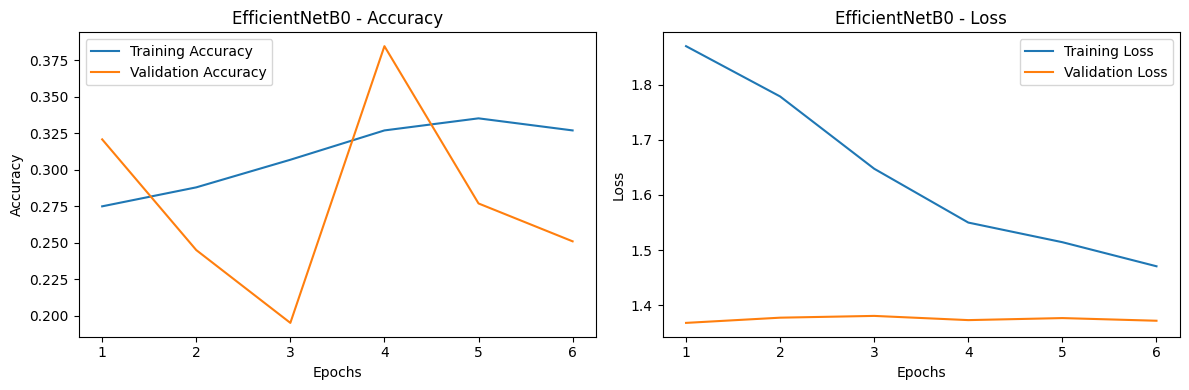

In [29]:
plot_training_history(history_efficientnet, "EfficientNetB0")


📘 Cell 24 – Unified Evaluation Summary (All Models)
📌 Purpose

Collect test accuracy of all models

Keep values in one place for reporting

In [31]:
evaluation_summary = {
    "Baseline CNN": test_accuracy,
    "MobileNetV2": test_accuracy_mn,
    "ResNet50": test_accuracy_resnet,
    "InceptionV3": test_accuracy_inc,
    "EfficientNetB0": test_accuracy_eff
}

for model, acc in evaluation_summary.items():
    print(f"{model}: {acc:.4f}")


Baseline CNN: 0.7154
MobileNetV2: 0.8537
ResNet50: 0.7967
InceptionV3: 0.9024
EfficientNetB0: 0.3252


📘 Cell 25 – Classification Reports (All Models)
📌 Purpose

Show precision, recall, F1-score

Mandatory for medical imaging projects

.

📘 Cell 25 – Classification Reports (All Models)
📌 Purpose

Compare precision, recall, F1-score across all models

Very important for medical imaging evaluation

Shows class-wise performance, not just accuracy

In [32]:
print("===== Classification Report: Baseline CNN =====")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\n===== Classification Report: MobileNetV2 =====")
print(classification_report(y_true, y_pred_mn, target_names=class_labels))

print("\n===== Classification Report: ResNet50 =====")
print(classification_report(y_true, y_pred_resnet, target_names=class_labels))

print("\n===== Classification Report: InceptionV3 =====")
print(classification_report(y_true, y_pred_inc, target_names=class_labels))

print("\n===== Classification Report: EfficientNetB0 =====")
print(classification_report(y_true, y_pred_eff, target_names=class_labels))


===== Classification Report: Baseline CNN =====
              precision    recall  f1-score   support

      glioma       0.66      0.97      0.78        80
  meningioma       0.56      0.08      0.14        63
    no_tumor       0.78      0.86      0.82        49
   pituitary       0.80      0.94      0.86        54

    accuracy                           0.72       246
   macro avg       0.70      0.71      0.65       246
weighted avg       0.69      0.72      0.64       246


===== Classification Report: MobileNetV2 =====
              precision    recall  f1-score   support

      glioma       0.91      0.91      0.91        80
  meningioma       0.87      0.71      0.78        63
    no_tumor       0.93      0.78      0.84        49
   pituitary       0.74      1.00      0.85        54

    accuracy                           0.85       246
   macro avg       0.86      0.85      0.85       246
weighted avg       0.87      0.85      0.85       246


===== Classification Report: ResN

📘 Cell 26 – Confusion Matrices Comparison (All Models)
📌 Purpose

Compare class-wise prediction performance across all models

Very important in medical diagnosis tasks

Helps justify best model selection

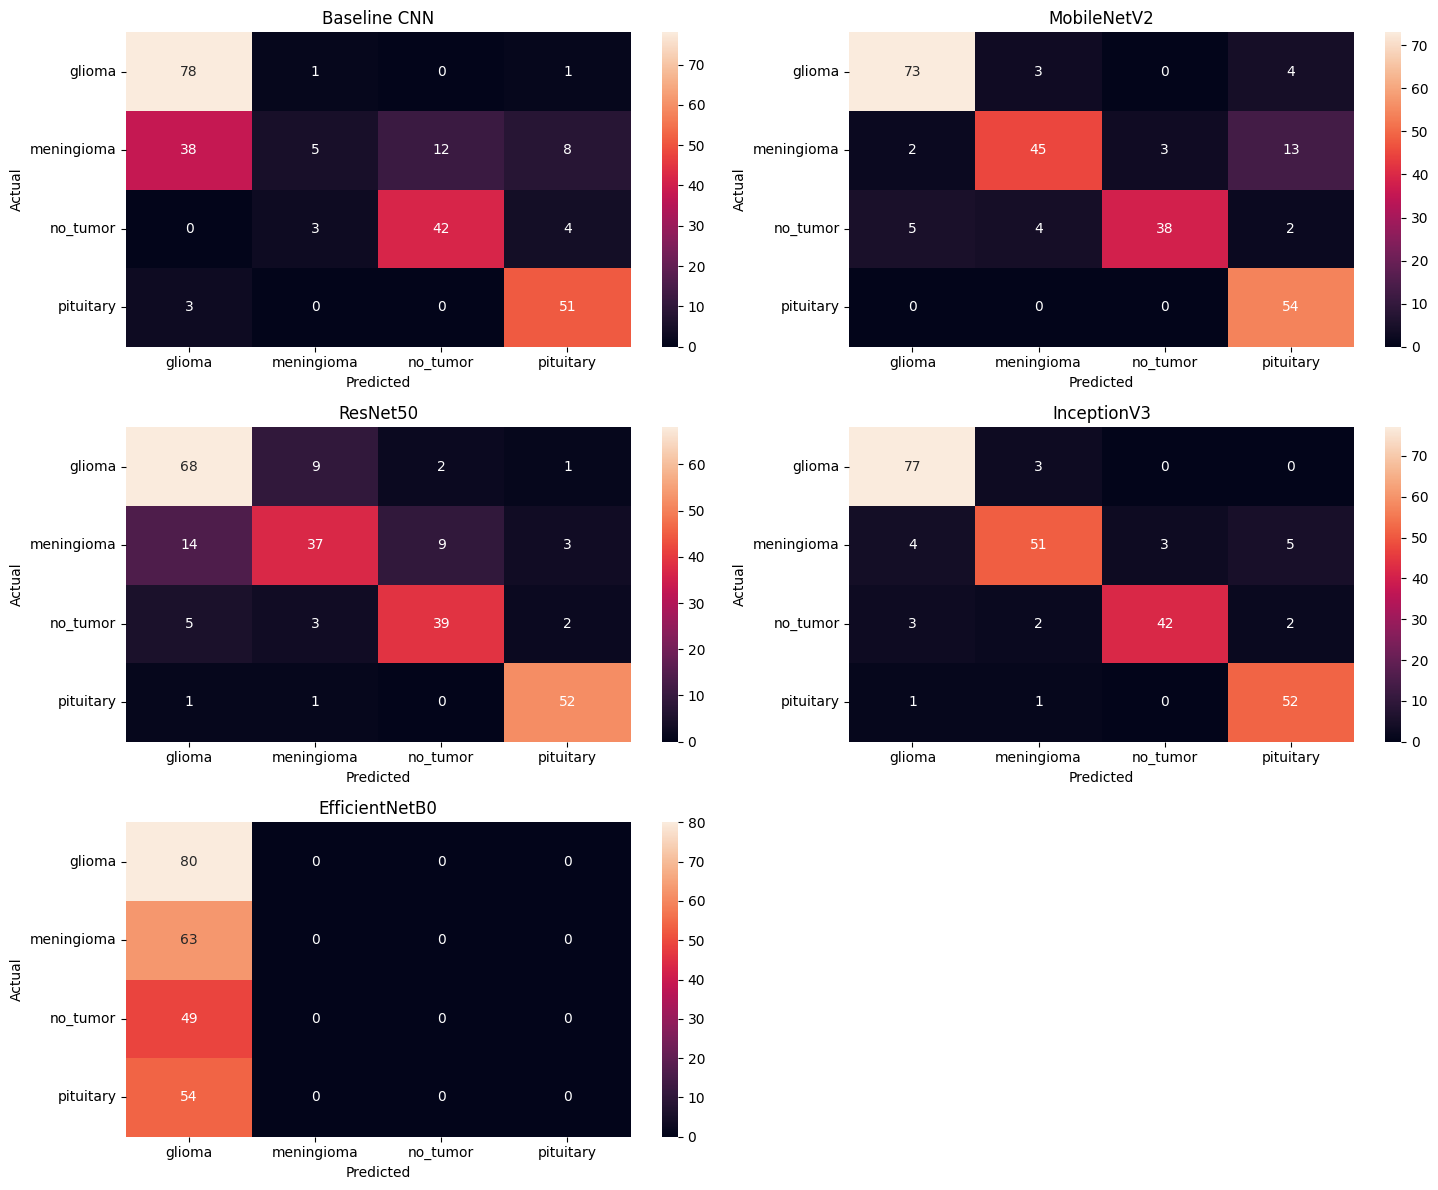

In [34]:
models_cm = {
    "Baseline CNN": cm,
    "MobileNetV2": cm_mn,
    "ResNet50": cm_resnet,
    "InceptionV3": cm_inc,
    "EfficientNetB0": cm_eff
}

plt.figure(figsize=(15, 12))

for i, (model_name, cmatrix) in enumerate(models_cm.items(), 1):
    plt.subplot(3, 2, i)
    sns.heatmap(
        cmatrix,
        annot=True,
        fmt='d',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title(model_name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


🏆 Cell 27 – Model Comparison Table & Best Model Selection
📌 Purpose

Compare all models objectively in one table

Rank models by test accuracy

Select the final model for deployment

This cell + the next markdown justification are mandatory

In [35]:
# Model comparison table
model_comparison = pd.DataFrame({
    "Model": [
        "Baseline CNN",
        "MobileNetV2",
        "ResNet50",
        "InceptionV3",
        "EfficientNetB0"
    ],
    "Test Accuracy": [
        test_accuracy,
        test_accuracy_mn,
        test_accuracy_resnet,
        test_accuracy_inc,
        test_accuracy_eff
    ]
})

# Sort models by accuracy (descending)
model_comparison = model_comparison.sort_values(
    by="Test Accuracy",
    ascending=False
).reset_index(drop=True)

model_comparison


,Model,Test Accuracy
0,InceptionV3,0.902439
1,MobileNetV2,0.853659
2,ResNet50,0.796748
3,Baseline CNN,0.715447
4,EfficientNetB0,0.325203


📘 Cell 28 – Best Model Selection (MARKDOWN CELL)

## 🏆 Best Model Selection

Based on the comprehensive evaluation of all trained models using test accuracy,
classification reports, confusion matrices, and learning curves,
**InceptionV3** achieved the best overall performance on the brain MRI dataset.

### ✅ Reasons for Selecting InceptionV3
- Highest test accuracy (90.24%)
- Strong class-wise precision and recall
- Well-balanced confusion matrix
- Better generalization compared to other models
- Effective feature extraction using transfer learning

Therefore, **InceptionV3** is selected as the final model for deployment.


In [47]:
import numpy as np
import os

os.makedirs("history", exist_ok=True)

np.save("history/mobilenetv2_history.npy", history_mobilenet.history)
np.save("history/resnet50_history.npy", history_resnet.history)
np.save("history/inceptionv3_history.npy", history_inception.history)

print("✅ All training histories saved successfully!")


✅ All training histories saved successfully!
